In [1]:
from IPython.display import Image

# A Python tutorial on validating gVirtualXRay

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to images generated with the state-of-the-art Monte Caro simulation packages.

**Material and Methods:** To generate an X-ray image with an analytic simulation, we must solve the [Beer-Lambert law](https://en.wikipedia.org/wiki/Beer%E2%80%93Lambert_law), which relies on attenuation coefficients. The first step in validating gVirtualXRay is to ascertain that the attenuation coefficients used in gVirtualXRay are in perfect agreement with those found in the literature. Ground truth data is provided in the [NIST Standard Reference Database 126](https://www.nist.gov/pml/x-ray-mass-attenuation-coefficients).

The second step is to simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate],(http://www.opengatecollaboration.org/) a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).

In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is generated using [SpekPy](https://bitbucket.org/spekpy/spekpy_release/wiki/Home). We use a tube voltage of 90kV, which is typical of chest x-ray procedures for a 70kg male patient. The total aluminium equivalent filtration is 3.2mm.

### Simulation parameters

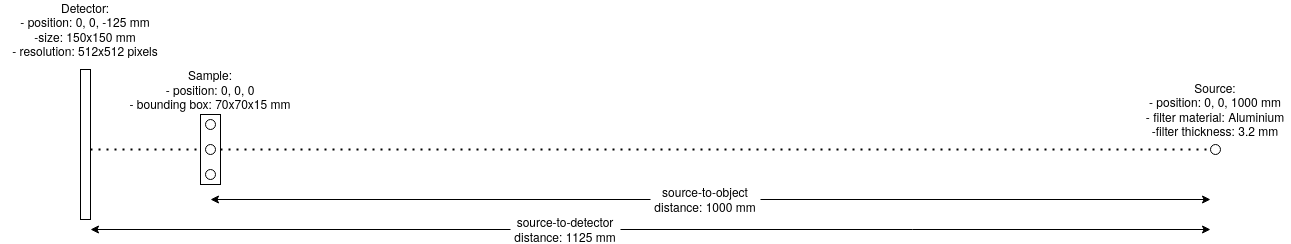

In [2]:
Image("doc/setup.png")

The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density. We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

### Sample composition

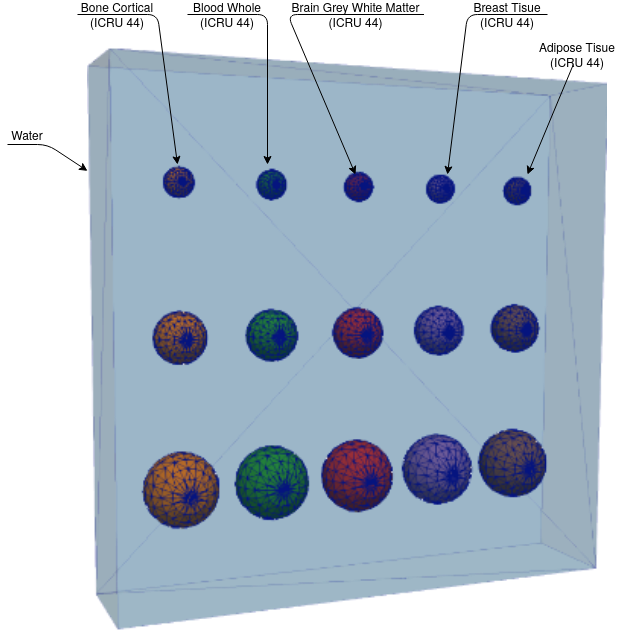

In [3]:
Image("doc/sample.png")

**Results:** The correlation coefficient between the attenuation coefficients computed with gVirtualXRay and those provided in NIST's *XCOM: Photon Cross Sections Database* is 100% for bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue. It demonstrates that the photon cross section calculations performed in gVirtualXRay are accurate. 


The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is ???%. The [zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is ???%. 
<!-- The [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is ???%.  -->
As MAPE is low, and ZNCC is close to 100%, we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations ran on supercomputers for days.

## Import packages

In [4]:
%matplotlib inline

import os # Locate files

import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

from scipy.stats import pearsonr # Compute the correlatio coefficient

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape

import SimpleITK as sitk # Load/Write MHA/MHD files

import viewscad # Use OpenSCAD to create STL files

import pyvista as pv # 3D visualisation
from pyvista import themes

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up

SimpleGVXR 1.0.1 (2021-04-01T17:18:35) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-04-01T17:18:28) [Compiler: GNU g++] on Linux


## Reference image

We first load the reference image that has been simulated using [Gate](http://www.opengatecollaboration.org/) wrapper for CERN's [Geant4](https://geant4.web.cern.ch/). Here we ignore scattering.

In [5]:
Image = sitk.GetArrayFromImage(sitk.ReadImage("GATE/output/energy_1e10.tif"))
Full_field = sitk.GetArrayFromImage(sitk.ReadImage("GATE/output/energy-total_white.tif"))
Dark_field = np.zeros(Full_field.shape)

Projections are then corrected to account for variations in beam homogeneity and in the pixel-to-pixel sensitivity of the detector. This is the projection with flat-field correction ($\mathbf{Proj}$):
\begin{equation}
\mathbf{Proj} = \frac{\boldsymbol{I} - \boldsymbol{D}}{\boldsymbol{F} - \boldsymbol{D}}
\label{eq:flat-fields}
\end{equation}
where $\boldsymbol{F}$ (full fields) and $\boldsymbol{D}$ (dark fields) are projection images without sample and acquired with and without the X-ray beam turned on respectively. 
<!-- Note that with an ideal detector ($\boldsymbol{R}_i=E_i$), pixels of $\boldsymbol{D}$ are null, and pixels of $\boldsymbol{F}$ are equal to $\sum_i E_i \; \boldsymbol{N}_i$. 
 -->

We now apply the flat-field correction to `Image`.

In [6]:
gate_image = (Image - Dark_field) / (Full_field - Dark_field)

gate_image = sitk.GetArrayFromImage(sitk.ReadImage("GATE/output/energy_1e10_flat2.tif"))

We plot the image using a linear look-up table and a power-law normalisation.

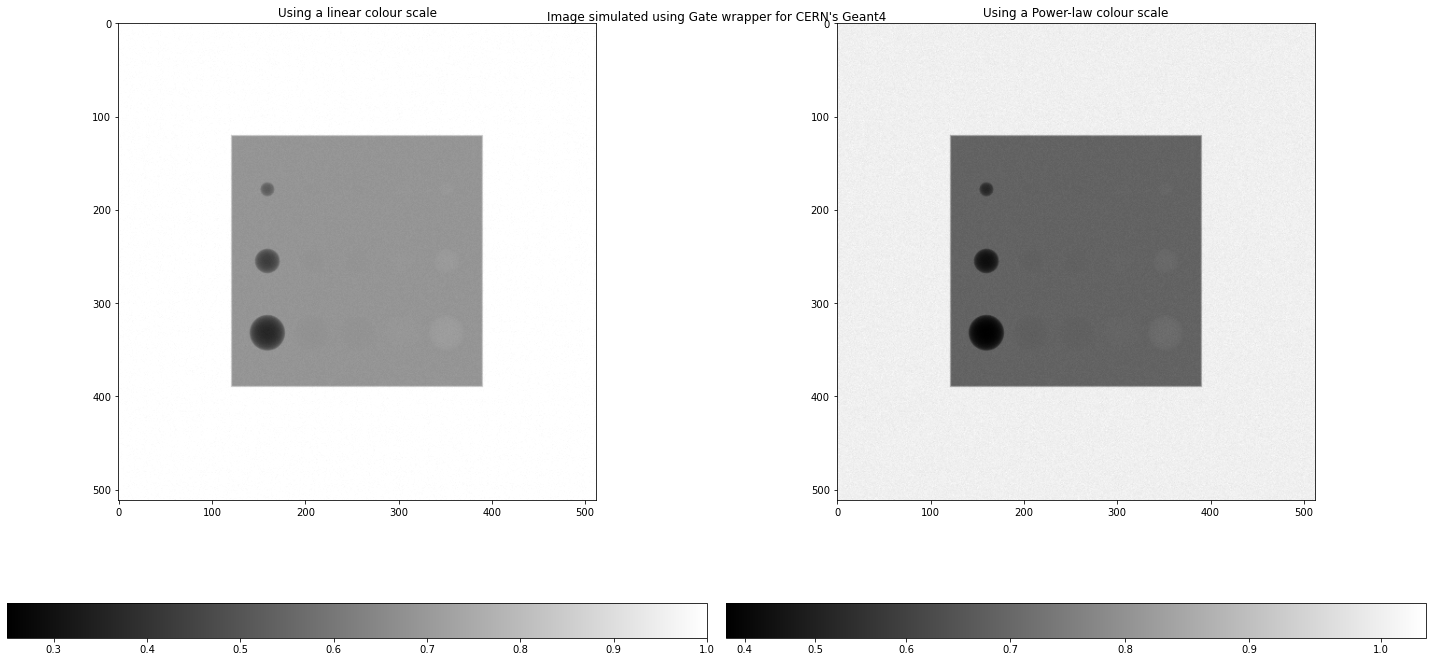

In [7]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using Gate wrapper for CERN's Geant4")

plt.subplot(121)
plt.imshow(gate_image, cmap="gray", vmin=0.25, vmax=1)
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(gate_image, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/reference_from_Gate.pdf')
plt.savefig('plots/reference_from_Gate.png')

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [8]:
json2gvxr.initGVXR("simulation.json", "OPENGL")

Create an OpenGL context: 800x450


## X-ray source

We create an X-ray source. It is a point source.

In [9]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, 0.0, 1000.0, 'mm']
	Source shape: PointSource


## Spectrum

The beam spectrum is generated using [SpekPy](https://bitbucket.org/spekpy/spekpy_release/wiki/Home). We decided to use a beam that is clinically appropriate. The chest phantom we used corresponds to a 70kg male patient. For a male chest x-ray, the tube voltage is in the range 80-120kV depending on technique, pathology and equipment used. The total aluminium equivalent filtration is approximately 3.2mm. `verbose=1` below is used to output the beam spectrum for Gate. To disable it, change it to `verbose=0`.

In [10]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=1)

/gate/source/mybeam/gps/emin 11.0 keV
/gate/source/mybeam/gps/emax 90.0 keV
/gate/source/mybeam/gps/histpoint 0.011 3.0
/gate/source/mybeam/gps/histpoint 0.0115 12.0
/gate/source/mybeam/gps/histpoint 0.012 40.0
/gate/source/mybeam/gps/histpoint 0.0125 148.0
/gate/source/mybeam/gps/histpoint 0.013 519.0
/gate/source/mybeam/gps/histpoint 0.0135 1565.0
/gate/source/mybeam/gps/histpoint 0.014 4090.0
/gate/source/mybeam/gps/histpoint 0.0145 9474.0
/gate/source/mybeam/gps/histpoint 0.015 19789.0
/gate/source/mybeam/gps/histpoint 0.0155 37826.0
/gate/source/mybeam/gps/histpoint 0.016 67047.0
/gate/source/mybeam/gps/histpoint 0.0165 111380.0
/gate/source/mybeam/gps/histpoint 0.017 174907.0
/gate/source/mybeam/gps/histpoint 0.0175 261254.0
/gate/source/mybeam/gps/histpoint 0.018 373324.0
/gate/source/mybeam/gps/histpoint 0.0185 513706.0
/gate/source/mybeam/gps/histpoint 0.019 684248.0
/gate/source/mybeam/gps/histpoint 0.0195 885574.0
/gate/source/mybeam/gps/histpoint 0.02 1116396.0
/gate/source

In [11]:
print("kvp:", json2gvxr.params["Source"]["Beam"]["kvp"])
print("filter material:", json2gvxr.params["Source"]["Beam"]["filter"][0])
print("filter thickness (in mm):", json2gvxr.params["Source"]["Beam"]["filter"][1])

kvp: 90
filter material: Al
filter thickness (in mm): 3.2


Plot the spectrum

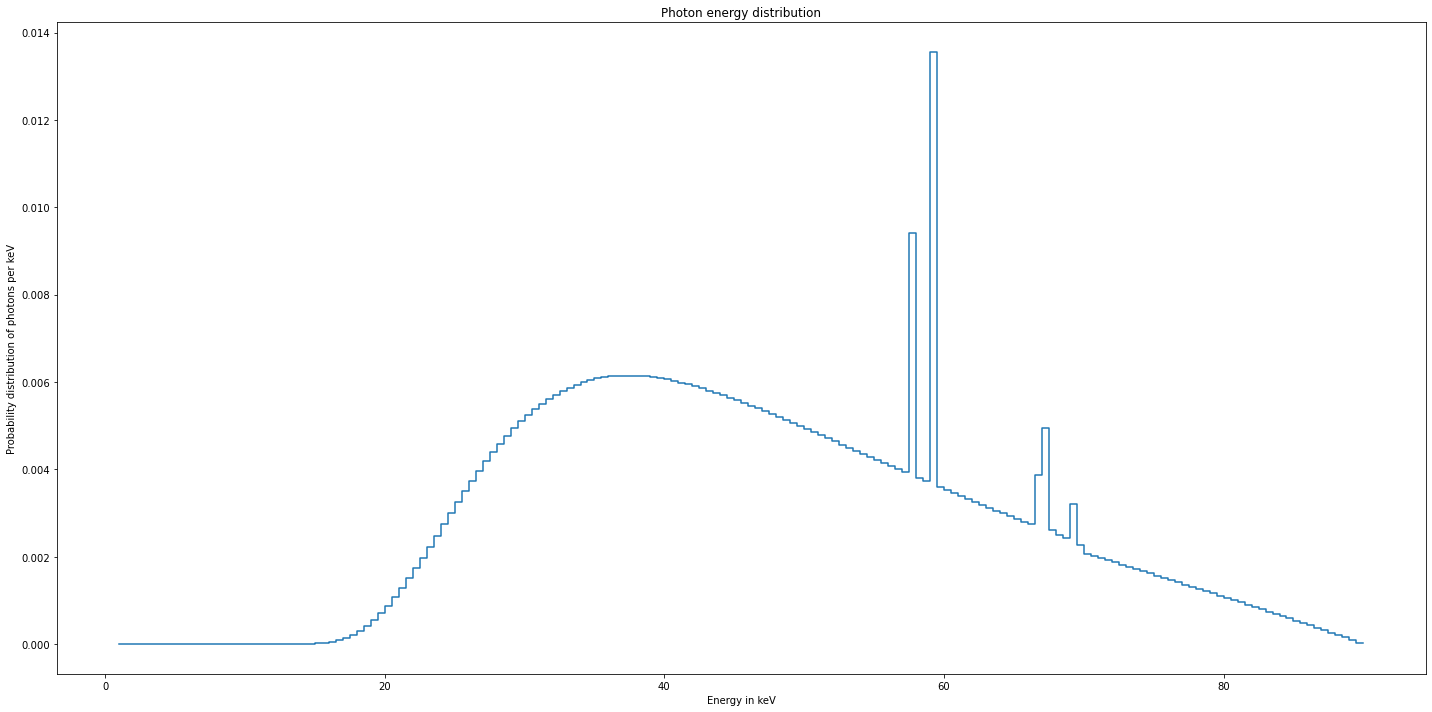

In [12]:
energy_set = sorted(spectrum.keys())
count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])
    
plt.figure(figsize= (20,10))

plt.plot(k, f / f.sum()) # Plot the spectrum
plt.xlabel('Energy in keV')
plt.ylabel('Probability distribution of photons per keV')
plt.title('Photon energy distribution')

plt.tight_layout()

plt.savefig('plots/spectrum.pdf')
plt.savefig('plots/spectrum.png')

## Detector

Create a digital detector

In [13]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, 0.0, -125.0, 'mm']
	Detector up vector: [0, 1, 0]
	Detector number of pixels: [512, 512]
	Pixel spacing: [0.29296875, 0.29296875, 'mm']


## Sample

We now create CAD models using [OpenSCAD](https://openscad.org/) and extract the corresponding STL files.

In [14]:
openscad_make_spheres_str = """

module make_column_of(sphere_radius, height, count)
{
    step = height / (count - 1);
    for (a = [0 : count - 1]) {
        offset = -height / 2 + step * a ;
        translate([0, offset, 0])
            sphere(sphere_radius[a], $fn=25);
    }
}

module make_row_of(radius, count, id)
{
    step = radius / (count - 1);
    for (a = [0 : count - 1]) {
        if (id == -1 || id == a) {
            offset = -radius / 2 + step * a ;
            translate([offset, 0, 0])
                children();
        }
    }
}

module make_spheres(sphere_radius, ring_radius, ring_count, column_height, column_count, id = -1)
{
    make_row_of(radius = ring_radius, count = ring_count, id = id)
        make_column_of(sphere_radius, height = column_height, count = column_count);
}
"""

The matrix

In [15]:
openscad_matrix_str = """

color("red")
    difference() {
        scale([70, 70, 15])
            cube(1, center = true);
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, -1);
}

"""

In [16]:
r = viewscad.Renderer()
r.render(openscad_matrix_str + openscad_make_spheres_str, outfile='gvxr/input/matrix.stl')

In [17]:
openscad_cube_str = """

color("red")
    scale([70, 70, 15])
        cube(1, center = true);

"""

In [18]:
r = viewscad.Renderer()
r.render(openscad_cube_str, outfile='gvxr/input/cube.stl')

The spheres

In [ ]:
openscad_col_str_set = []

for i in range(5):
    openscad_col_str_set.append("""
    color("blue")
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, """ + str(i) + ");")
        
    r = viewscad.Renderer()
    r.render(openscad_col_str_set[-1] + openscad_make_spheres_str, outfile='gvxr/input/col_' + str(i) + '.stl')

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [ ]:
json2gvxr.initSamples(verbose=2)

## Mass attenuation coefficients

Before computing an X-ray image, we can check that the mass attenuation coefficients are accurate. We downloaded tabulated data from the XCOM database and compare the values with the ones used in gVirtualXRay. We do it for relevant chemical elements from [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html):

- [Carbon](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z06.html)
- [Chlorine](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z17.html)
- [Hydrogen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z01.html)
- [Iron](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z26.html)
- [Magnesium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z12.html)
- [Nitrogen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z07.html)
- [Oxygen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z08.html)
- [Phosphorus](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z15.html)
- [Potassium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z19.html)
- [Sodium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z11.html)
- [Sulfur](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z16.html)

In [ ]:
elements = ["Carbon", "Chlorine", "Hydrogen", "Iron", "Magnesium", "Nitrogen", "Oxygen", "Potassium", "Sodium", "Sulfur"] #  "Phosphorus"]#, ]

i = 1

plt.figure(figsize= (20,40))

for element in elements:
    if os.path.isfile("gvxr/input/" + element + ".csv"):
        df = pd.read_csv("gvxr/input/" + element + ".csv")
        
        gvxr_mu_rho = []
        gvxr_energy = []
        for energy_id in range(len(df["Photon in MeV"])):
            if energy_id == len(df["Photon in MeV"]) - 1 or energy_id == 0:
                energy = df["Photon in MeV"][energy_id]
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id + 1]:
                energy = df["Photon in MeV"][energy_id] - df["Photon in MeV"][energy_id] * 1e-3
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id - 1]:
                energy = df["Photon in MeV"][energy_id] + df["Photon in MeV"][energy_id] * 1e-3
            else:
                energy = df["Photon in MeV"][energy_id]
            
            gvxr_mu_rho.append(gvxr.getMassAttenuationFromElement(element, energy, "MeV"))
            gvxr_energy.append(energy)
        
        df["Mass attenuation coefficient (gVirtualXRay)"] = gvxr_mu_rho
        df["|XCOM - gVirtualXRay| / XCOM (in %)"] = np.abs(np.array(100 * (df["Mass attenuation coefficient"] - gvxr_mu_rho) / df["Mass attenuation coefficient"])).astype(int)
        
        if df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean() > 1.0:
            print("\tWARNING:")
            print("\t\tAverage:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean())
            print("\t\tMax:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].abs().max())
        
        df.to_csv("../data/" + element + "-validation.csv", index=False )
        
        plt.subplot(6, 2, i)
        plt.title("Mass attenuation in mu / rho:  " + element)
        plt.plot(df["Photon in MeV"], df["Mass attenuation coefficient"], label="XCOM", color="b")
        plt.scatter(gvxr_energy, gvxr_mu_rho, label="gVirtualXRay", s=15, color="r")
        plt.legend()
        plt.xscale('log')
        plt.yscale('log')
        
        i = i + 1
        
plt.tight_layout()

plt.savefig('plots/mass_attenuation_coefficients_from_elements.pdf')
plt.savefig('plots/mass_attenuation_coefficients_from_elements.png')

And for some clinically relevant materials from [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html):

- [Adipose Tissue (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/adipose.html)
- [Blood, Whole (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/blood.html)
- [Bone, Cortical (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html)
- [Brain, Grey/White Matter (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/brain.html)
- [Breast Tissue (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/breast.html)
- [Water, Liquid](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/water.html)

In [ ]:
i = 1

plt.figure(figsize= (20,20))

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    if os.path.isfile("gvxr/input/" + label + ".csv"):
        df = pd.read_csv("gvxr/input/" + label + ".csv")
        
        gvxr_mu_rho = []
        gvxr_energy = []

        for energy_id in range(len(df["Photon in MeV"])):
            if energy_id == len(df["Photon in MeV"]) - 1 or energy_id == 0:
                energy = df["Photon in MeV"][energy_id]
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id + 1]:
                energy = df["Photon in MeV"][energy_id] - df["Photon in MeV"][energy_id] * 1e-3
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id - 1]:
                energy = df["Photon in MeV"][energy_id] + df["Photon in MeV"][energy_id] * 1e-3
            else:
                energy = df["Photon in MeV"][energy_id]

            gvxr_mu_rho.append(gvxr.getMassAttenuationCoefficient(label, energy, "MeV"))
            gvxr_energy.append(energy)

        
        df["Mass attenuation coefficient (gVirtualXRay)"] = gvxr_mu_rho
        df["|XCOM - gVirtualXRay| / XCOM (in %)"] = np.abs(np.array(100 * (df["Mass attenuation coefficient"] - gvxr_mu_rho) / df["Mass attenuation coefficient"])).astype(int)
        
        if df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean() > 1.0:
            print("\tWARNING:")
            print("\t\tAverage:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean())
            print("\t\tMax:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].abs().max())

        df.to_csv("../data/" + label + "-validation.csv", index=False)
        
        plt.subplot(3, 2, i)
        plt.title("Mass attenuation in mu / rho:  " + label)
        plt.plot(df["Photon in MeV"], df["Mass attenuation coefficient"], label="XCOM", color="b")
        plt.scatter(gvxr_energy, gvxr_mu_rho, label="gVirtualXRay", s=15, color="r")
        plt.legend()
        plt.xscale('log')
        plt.yscale('log')
        
        corr, _ = pearsonr(df["Mass attenuation coefficient"], gvxr_mu_rho)
        print(label + '\'s Pearsons correlation: %.3f' % corr)
        
        i = i + 1
        
plt.tight_layout()

plt.savefig('plots/mass_attenuation_coefficients_from_ICRU44.pdf')
plt.savefig('plots/mass_attenuation_coefficients_from_ICRU44.png')

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [ ]:
gvxr.displayScene()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(719.6787109375)
gvxr.setSceneRotationMatrix([0.7624880075454712, 0.09040657430887222, -0.6406543850898743, 0.0,
                             0.05501500517129898, 0.9775413870811462, 0.20342488586902618, 0.0,
                             0.6446591019630432, -0.190354123711586, 0.7403913140296936, 0.0,
                             0.0, 0.0, 0.0, 1.0])

gvxr.displayScene()

In [ ]:
screenshot = gvxr.takeScreenshot()

In [ ]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off.pdf')
plt.savefig('plots/screenshot-beam-off.png')

Compute an X-ray image and add it to the list of projections

In [ ]:
x_ray_image = np.array(gvxr.computeXRayImage())

Normalise the data

In [ ]:
total_energy = 0.0
for energy, count in zip(energy_set, count_set):
    total_energy += energy * count

In [ ]:
white = np.ones(x_ray_image.shape) * total_energy / 1000.0
dark = np.zeros(x_ray_image.shape)

x_ray_image = (x_ray_image - dark) / (white - dark)

Save the corresponding image

In [ ]:
volume = sitk.GetImageFromArray(x_ray_image)
sitk.WriteImage(volume, 'gvxr/output/projection.mha')

In [ ]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay\nwithout the response of the detector")

plt.subplot(121)
plt.imshow(x_ray_image, cmap="gray", vmin=0.25, vmax=1)
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_without_detector_response.pdf')
plt.savefig('plots/x_ray_image_without_detector_response.png')

## Compute the L-buffers then the energy fluence

Compute the L-buffers

In [ ]:
NoneType = type(None)
import copy

L_buffer_set = {}

L_buffer_inner = None
L_buffer_outer = None

gvxr.disableArtefactFiltering() # Missing the spheres
gvxr.enableArtifactFilteringOnCPU() # Missing the spheres

gvxr.enableArtifactFilteringOnGPU() # Missing the spheres + negative


for sample in json2gvxr.params["Samples"]:
    L_buffer_set[sample["Label"]] = np.array(gvxr.computeLBuffer(sample["Label"]))
    
    if sample["Type"] == "inner":
        
#         volume = sitk.GetImageFromArray(L_buffer_set[sample["Label"]])
#         sitk.WriteImage(volume, '2-L-buffer_' + sample["Label"] + '.mha')

        if isinstance(L_buffer_inner, NoneType):
            L_buffer_inner = copy.deepcopy(L_buffer_set[sample["Label"]])
        else:
            L_buffer_inner += L_buffer_set[sample["Label"]]
    else:
        L_buffer_outer = sample["Label"]

if not isinstance(L_buffer_outer, NoneType):
    L_buffer_set[L_buffer_outer] -= L_buffer_inner
    
#     volume = sitk.GetImageFromArray(L_buffer_set[L_buffer_outer])
#     sitk.WriteImage(volume, '2-L-buffer_' + L_buffer_outer + '.mha')

Integrate the energy for every energy channe

In [ ]:
x_ray_image_manual = np.zeros(x_ray_image.shape)

for energy, count in zip(energy_set, count_set):

    mu_x = np.zeros(x_ray_image.shape)

    for sample in json2gvxr.params["Samples"]:
        mu = gvxr.getLinearAttenuationCoefficient(sample["Label"], energy, "keV")
        mu_x += L_buffer_set[sample["Label"]] * mu

    x_ray_image_manual += (energy * count) * np.exp(-mu_x)

Normalise the data

In [ ]:
x_ray_image_manual = (x_ray_image_manual - dark) / (white * 1000 - dark)

Save the corresponding image

In [ ]:
volume = sitk.GetImageFromArray(x_ray_image_manual)
sitk.WriteImage(volume, 'projection_manual.mha')

In [ ]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay's L-buffers\nwithout the response of the detector")

plt.subplot(121)
plt.imshow(x_ray_image_manual, cmap="gray", vmin=0.25, vmax=1)
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image_manual, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_without_detector_response.pdf')
plt.savefig('plots/x_ray_image_without_detector_response.png')

## Model the camera response

Load the response

In [ ]:
detector_response = np.loadtxt("../Gate/data/responseDetector.txt")

Display the response

In [ ]:
plt.figure(figsize= (20,10))
# plt.title("Detector response")
plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector response: δ(E) (in keV)')

plt.tight_layout()

plt.savefig('plots/detector_response.pdf')
plt.savefig('plots/detector_response.png')

Integrate the energy for every energy channe

In [ ]:
def interpolate(a_low, a_high, a0, b_low, b_high):
    return b_low + (b_high - b_low) * (a0 - a_low) / (a_high - a_low)

def find_nearest(a, a0, b):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    
    # a[idx] <= a0 <= a[idx+1]
    if a[idx] < a0:
        return interpolate(a[idx], a[idx + 1], a0, b[idx], b[idx + 1])
    # a[idx - 1] <= a0 <= a[idx]
    else:
        return interpolate(a[idx - 1], a[idx], a0, b[idx - 1], b[idx])

In [ ]:
x_ray_image_response = np.zeros(x_ray_image.shape)

for energy, count in zip(energy_set, count_set):

    mu_x = np.zeros(x_ray_image.shape)

    for sample in json2gvxr.params["Samples"]:
        mu = gvxr.getLinearAttenuationCoefficient(sample["Label"], energy, "keV")
        mu_x += L_buffer_set[sample["Label"]] * mu

    corrected_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])

    x_ray_image_response += (corrected_energy * count) * np.exp(-mu_x)

Compute the full field image with the response of the detector

In [ ]:
total_energy = 0.0
for energy, count in zip(energy_set, count_set):
    corrected_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])
    total_energy += corrected_energy * count
    
white = np.ones(dark.shape) * total_energy

Normalise the data

In [ ]:
x_ray_image_response = (x_ray_image_response - dark) / (white - dark)

Save the corresponding image

In [ ]:
volume = sitk.GetImageFromArray(x_ray_image_response)
sitk.WriteImage(volume, 'x_ray_image_response.mha')

In [ ]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay's L-buffers\nwith the response of the detector")

plt.subplot(121)
plt.imshow(x_ray_image_response, cmap="gray", vmin=0.25, vmax=1)
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image_response, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_with_detector_response.pdf')
plt.savefig('plots/x_ray_image_with_detector_response.png')

## Interactive 3D visualisation

In [ ]:
# %matplotlib widget

# my_theme = themes.DarkTheme()
# my_theme.color = 'red'
# my_theme.lighting = False
# my_theme.show_edges = True
# my_theme.axes.box = True

# pv.global_theme.load_theme(my_theme)

plotter = pv.Plotter(notebook=True, window_size=(512 * 4, 256 * 4))
plotter.add_title("3D Visualisation")
i = 0

colours = list(mcolors.TABLEAU_COLORS)
colour_id = 0

# Add the samples
for sample in json2gvxr.params["Samples"]:
   
    if sample["Label"] == "H2O":
        opacity = 0.25
    else:
        opacity = 1.0

    mesh = pv.read(sample["Path"])

    colour = mcolors.to_rgb(colours[colour_id])
    plotter.add_mesh(mesh, opacity=opacity, color=(colour[0], colour[1], colour[2]))
    colour_id += 1

# Add the source
source_position = json2gvxr.params["Source"]["Position"]
source_position = np.array([source_position[0], source_position[1], source_position[2]])

sphere = pv.Sphere(radius=10, center=source_position)
colour = mcolors.to_rgb(colours[colour_id])
plotter.add_mesh(sphere, color=(colour[0], colour[1], colour[2]))
colour_id += 1

# Add the detector
detector_position = json2gvxr.params["Detector"]["Position"]
detector_position = np.array([detector_position[0], detector_position[1], detector_position[2]])

detector_direction = detector_position - source_position
plane = pv.Plane(center=detector_position,
                 direction=detector_direction,
                 i_size=json2gvxr.params["Detector"]["Size"][0],
                 j_size=json2gvxr.params["Detector"]["Size"][1],
                 i_resolution=1, j_resolution=1)

# Creating a custom RGBA image
cmap = get_cmap("gray")
norm = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
hue = norm(np.fliplr(x_ray_image_response.T).ravel())
colors = (cmap(hue) * 255.0).astype(np.uint8)
image = colors.reshape((x_ray_image_response.shape[0], x_ray_image_response.shape[1], 4), order="F")

texture = pv.numpy_to_texture(image)
plotter.add_mesh(plane, texture=texture)

cpos = plotter.show(cpos=[(-965.0666772245627, 47.72249675199398, 1249.8218575579394),
                          (0.0, 0.0, 442.5),
                          (0, 1, 0)], jupyter_backend='static')

Update the 3D visualisation and take a screenshot

In [ ]:
gvxr.displayScene()
screenshot = gvxr.takeScreenshot()

In [ ]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-on.pdf')
plt.savefig('plots/screenshot-beam-on.png')

## Comparison the analytic simulation with the Monte Carloa simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), and
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)).

In [ ]:
MAPE = mape(gate_image, x_ray_image_response)
ZNCC = np.mean((gate_image - gate_image.mean()) / gate_image.std() * (x_ray_image_response - x_ray_image_response.mean()) / x_ray_image_response.std())

print("MAPE:", "{0:0.2f}".format(100 * MAPE) + "%")
print("ZNCC:", "{0:0.2f}".format(100 * ZNCC) + "%")

### Qualitative validation

Checkboard comparison

In [ ]:
absolute_error = np.abs(gate_image - x_ray_image_response)
comp_equalized = compare_images(gate_image, x_ray_image_response, method='checkerboard', n_tiles=(15,15))

plt.figure(figsize= (20,10))

plt.subplot(141)
plt.imshow(gate_image, cmap="gray", vmin=0.25, vmax=1)
plt.title("Gate (ground truth)")

plt.subplot(142)
plt.imshow(x_ray_image_response, cmap="gray", vmin=0.25, vmax=1)
plt.title("gVirtualXRay")

plt.subplot(143)
plt.imshow(comp_equalized, cmap="gray", vmin=0.25, vmax=1)
plt.title("gVirtualXRay & Gate (checkerboard comparison)")

plt.subplot(144)
plt.imshow(absolute_error, cmap="gray", vmin=0.25, vmax=1)
plt.title("Absolute error")

plt.tight_layout()

plt.savefig('plots/comparison.pdf')
plt.savefig('plots/comparison.png')

Plot the profiles

In [ ]:
plt.figure(figsize= (10,20))

offset_line = 20 * (json2gvxr.params["Source"]["Position"][2] - json2gvxr.params["Detector"]["Position"][2]) / json2gvxr.params["Source"]["Position"][2]

spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]

x = np.arange(0.0, json2gvxr.params["Detector"]["Size"][0], spacing)
print(x.shape)

plt.subplot(311)
plt.title("Profiles (Top line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 - offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x, x_ray_image_response[y_coord], label="gVirtualXRay with detector response", color="orange")
plt.plot(x, x_ray_image_manual[y_coord], label="gVirtualXRay without detector response", color="blue")
plt.plot(x, gate_image[y_coord], label="Gate", color="green")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.legend()

plt.subplot(312)
plt.title("Profiles (Central line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)
plt.plot(x, x_ray_image_response[y_coord], color="orange")
plt.plot(x, x_ray_image_manual[y_coord], color="blue")
plt.plot(x, gate_image[y_coord], color="green")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.subplot(313)
plt.title("Profiles (Bottom line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 + offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x, x_ray_image_response[y_coord], color="orange")
plt.plot(x, x_ray_image_manual[y_coord], color="blue")
plt.plot(x, gate_image[y_coord], color="green")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.tight_layout()

plt.savefig('plots/profiles.pdf')
plt.savefig('plots/profiles.png')

Plot the same profiles but of the checkerboard comparison. The noisy parts correspond to the Monte Carlo simulation. Both the Monte Carlo and analytic simulations are comparable.

In [ ]:
plt.figure(figsize= (10,20))

offset_line = 20 * (json2gvxr.params["Source"]["Position"][2] - json2gvxr.params["Detector"]["Position"][2]) / json2gvxr.params["Source"]["Position"][2]

spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]

x = np.arange(0.0, json2gvxr.params["Detector"]["Size"][0], spacing)

x_gvxr = []
x_gate = []
temp = []
use_gate = True;

for i in range(x_ray_image_response.shape[1]):
    
    temp.append(i)
    
    if not i % 10 and i is not 0:
        temp.append(i+1)
        if use_gate:
            x_gate.append(temp)
        else:
            x_gvxr.append(temp)
            
        temp = []
        temp.append(i-1)
        
        use_gate = not use_gate


plt.subplot(311)
plt.title("Profiles (Top line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 - offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])

i = 0
for sub_x in x_gvxr:
    y = x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (not noisy)", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1
 
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.legend()

plt.subplot(312)
plt.title("Profiles (Central line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)

i = 0
for sub_x in x_gvxr:
    y = x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (not noisy)", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.subplot(313)
plt.title("Profiles (Bottom line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 + offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])

i = 0
for sub_x in x_gvxr:
    y = x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (not noisy)", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.tight_layout()

plt.savefig('plots/profiles-checkerboard.pdf')
plt.savefig('plots/profiles-checkerboard.png')

## All done

Destroy the window

In [ ]:
# gvxr.destroyAllWindows()